In [1]:
%load_ext autoreload
%autoreload 2
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import sys
import importlib
import coffea.util as util
import time
import json
import os
import numba as nb
import awkward.numba

sys.path.append("../analysisTools/")
from analysisTools import Analyzer
from analysisTools import loadSchema
import analysisTools as tools
import analysisSubroutines as routines

sample_cfg_dir = "../configs/sample_configs/"
histo_cfg_dir = "../configs/histo_configs/"
cut_cfg_dir = "../configs/cut_configs/"

In [2]:
# load in a "sample config file" for the 2018 signal samples
with open(sample_cfg_dir+"signal_v2_2018_aEM.json","r") as fin:
    sig_cfg = json.load(fin)

In [3]:
# look at one of the entries
sig_cfg[10]

{'location': '/store/group/lpcmetx/iDMe//Samples/Ntuples/signal_v2/2018/Mchi-22p0_dMchi-4p0/ctau-10/',
 'Mchi': 22.0,
 'dMchi': 4.0,
 'ctau': 10,
 'name': 'sig_Mchi-22.0_dMchi-4.0_ct-10',
 'sum_wgt': 0.00014601059683627682,
 'type': 'signal',
 'year': 2018,
 'alphaD': 'aEM',
 'xsec': 99.19946999999999,
 'nFiles': 8,
 'num_events': 225012,
 'blacklist': []}

Here's what this information means:
- `location` : the directory where all the `.root` files for this signal sample are located 
- `Mchi`, `dMchi`, `ctau` : model parameters for this signal point
- `name` : name for the signal sample
- `sum_wgt` : sum of the Monte Carlo event weights for all events in this sample (relevant for filling histograms)
- `type`,`year` : Information on what kind of sample this is (signal, in this case), and what data-taking year the Monte Carlo generation was configured to reproduce
- `alphaD` : parameter setting for the dark matter U(1) coupling constant. `aEM` means it's set equal to the electromagnetic coupling.
- `xsec` : production cross section for this signal
- `nFiles` : number of `.root` files in the sample
- `num_events` : number of events in the sample
- `blacklist` : list of any corrupted or unusable `.root` files (rare for this to happen)

Now, let's make a list of all the `.root` files for this sample. We will use the `XRootD` package to interact with the `eos` filesystem, where the `.root` files are stored.

In [4]:
from XRootD import client
loc = sig_cfg[10]['location']
blacklist = sig_cfg[10]['blacklist']
xrdClient = client.FileSystem("root://cmseos.fnal.gov")
status, flist = xrdClient.dirlist(loc) # get list of files in directory
# select only non-blacklisted root files, prepend the root://cmsxrootd.fnal.gov/ to the file paths
fullList = ["root://cmseos.fnal.gov/"+loc+"/"+item.name for item in flist if (('.root' in item.name) and (item.name not in blacklist))]

In [5]:
fullList

['root://cmseos.fnal.gov//store/group/lpcmetx/iDMe//Samples/Ntuples/signal_v2/2018/Mchi-22p0_dMchi-4p0/ctau-10//ntuples_Mchi-22p0_dMchi-4p0_ctau-10_00.root',
 'root://cmseos.fnal.gov//store/group/lpcmetx/iDMe//Samples/Ntuples/signal_v2/2018/Mchi-22p0_dMchi-4p0/ctau-10//ntuples_Mchi-22p0_dMchi-4p0_ctau-10_01.root',
 'root://cmseos.fnal.gov//store/group/lpcmetx/iDMe//Samples/Ntuples/signal_v2/2018/Mchi-22p0_dMchi-4p0/ctau-10//ntuples_Mchi-22p0_dMchi-4p0_ctau-10_02.root',
 'root://cmseos.fnal.gov//store/group/lpcmetx/iDMe//Samples/Ntuples/signal_v2/2018/Mchi-22p0_dMchi-4p0/ctau-10//ntuples_Mchi-22p0_dMchi-4p0_ctau-10_03.root',
 'root://cmseos.fnal.gov//store/group/lpcmetx/iDMe//Samples/Ntuples/signal_v2/2018/Mchi-22p0_dMchi-4p0/ctau-10//ntuples_Mchi-22p0_dMchi-4p0_ctau-10_04.root',
 'root://cmseos.fnal.gov//store/group/lpcmetx/iDMe//Samples/Ntuples/signal_v2/2018/Mchi-22p0_dMchi-4p0/ctau-10//ntuples_Mchi-22p0_dMchi-4p0_ctau-10_05.root',
 'root://cmseos.fnal.gov//store/group/lpcmetx/iDMe//

## Using `uproot` to open files

Now we will use the uproot package to load in a ROOT file and look at its contents. All of the event data is stored in a `TTree` object called `outT` inside the `ntuples` directory of the file.

In [16]:
# open the first file in the list
t = uproot.open(fullList[0])['ntuples/outT']

In [18]:
t

<TTree 'outT' (296 branches) at 0x7f52330b9d90>

We see that the TTree has 296 "branches". Each branch records the value(s) of some variable for each event (e.g. electron $p_T$ or missing transverse energy)

In [19]:
print("\n".join(t.keys()))

trigFired
trigFired16
trigFired17
trigFired18
eventNum
lumiSec
runNum
METFiltersFailBits
nElectron
Electron_pt
Electron_eta
Electron_etaErr
Electron_phi
Electron_phiErr
Electron_IDcutVeto
Electron_IDcutLoose
Electron_IDcutMed
Electron_IDcutTight
Electron_IDmvaIso90
Electron_IDmvaIso80
Electron_IDmvaIsoLoose
Electron_IDmva90
Electron_IDmva80
Electron_IDmvaLoose
Electron_angRes
Electron_e
Electron_vxy
Electron_vz
Electron_dxy
Electron_dxyErr
Electron_dz
Electron_dzErr
Electron_trkChi2
Electron_trkIso
Electron_trkRelIso
Electron_calIso
Electron_calRelIso
Electron_PFIso4
Electron_PFRelIso4
Electron_PFIso3
Electron_PFRelIso3
Electron_PFIso8
Electron_PFRelIso8
Electron_PFIso
Electron_PFRelIso
Electron_trkProb
Electron_numTrackerHits
Electron_numPixHits
Electron_numStripHits
Electron_charge
nLptElectron
LptElectron_pt
LptElectron_eta
LptElectron_etaErr
LptElectron_phi
LptElectron_phiErr
LptElectron_ID
LptElectron_angRes
LptElectron_e
LptElectron_vxy
LptElectron_vz
LptElectron_dxy
LptElectron_

There are a lot of entries here! But they're mostly grouped by name, so e.g. `Electron_*` are kinematic quantities for the electrons in each event, `LptElectron_*` are for the low-$p_T$ electrons, and so on.

Let's look at the electrons as an example

In [20]:
ele_pt = t['Electron_pt'].array()
print(ele_pt[:5]) # print the electron pT for the first 5 events

[[], [], [], [], [4.74, 2.29]]


The array `Electron_pt` is a *jagged array*, meaning each event has a variable number of entries (i.e. a variable number of electrons). Jagged arrrays are handled by the `awkward` package. 

Since this is a signal sample, we can also look at variables for the *generator-level* electron and positron in the iDM signal. These are accessed via the `GenEle_*` and `GenPos_*` branches

In [21]:
t["GenEle_pt"].array()

<Array [7.47, 4.14, 1.9, ... 10.2, 1.93, 6.49] type='30486 * float32'>

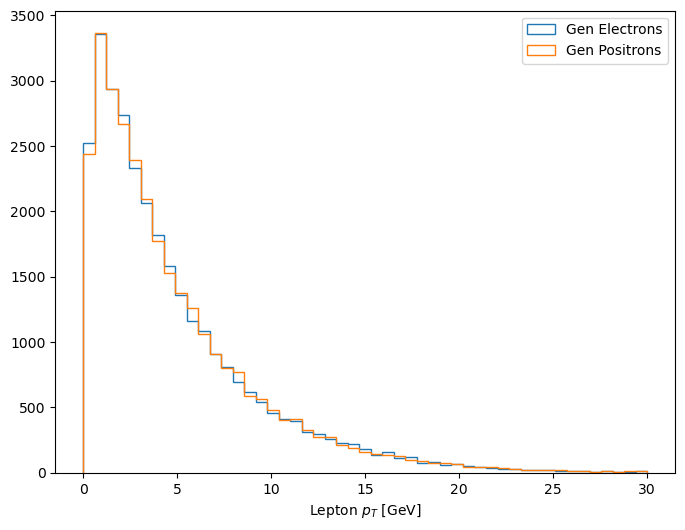

In [22]:
# make a histogram of the gen electron and positron pT
plt.figure(figsize=(8,6))
bins = np.linspace(0,30,50)
h1 = plt.hist(t['GenEle_pt'].array(),bins=bins,histtype='step',label='Gen Electrons')
h1 = plt.hist(t['GenPos_pt'].array(),bins=bins,histtype='step',label='Gen Positrons')
plt.xlabel("Lepton $p_T$ [GeV]")
plt.legend()

Text(0, 0.5, 'Positron $p_T$ [GeV]')

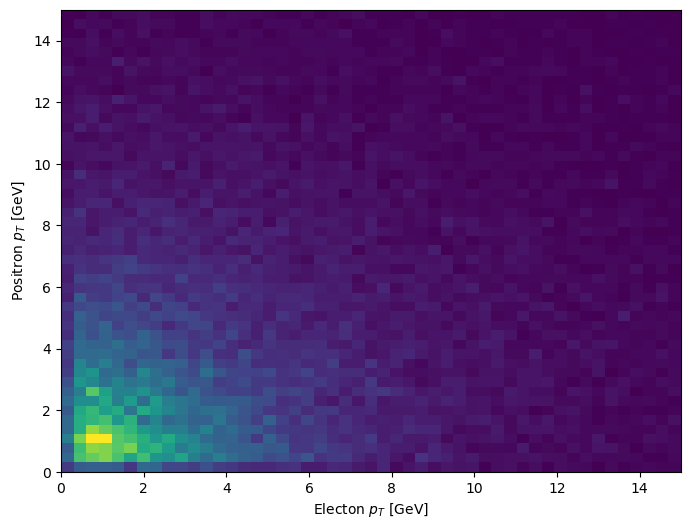

In [23]:
# make a 2D histogram of the gen electron and positron pT
plt.figure(figsize=(8,6))
bins = np.linspace(0,15,50)
h1 = plt.hist2d(t['GenEle_pt'].array(),t['GenPos_pt'].array(),bins=bins)
plt.xlabel("Electon $p_T$ [GeV]")
plt.ylabel("Positron $p_T$ [GeV]")

## An easier way to do file I/O -- `NanoEvents`

Uproot is nice for interacting with single files with a few branches, but gets a little cumbersome when there are many branches with long names. Instead, we can use the `coffea` package to interact with the files using the `NanoEvents` format. Here, I use the `loadNano` function from the `analysisTools` python file we imported at the top of tthe notebook. Go check out the source code if you want to know more about how this works!

In [6]:
inFile = fullList[0]
events = tools.loadNano(inFile)

The `events` object now allows us to access event data in a structured way based on the branch names. For instance, all the `Electron` information can be accessed via `events.Electron` etc.

In [7]:
events.fields

['GenEle',
 'trigFired',
 'trigFired17',
 'Photon',
 'ootPhoton',
 'lumiSec',
 'GenPart',
 'GenEleClosestReg',
 'nGenPosTrkMatches',
 'LptElectron',
 'GenPosClosestReg',
 'genEleNearTk',
 'nGenEleTrkMatches',
 'trigFired16',
 'GenEleClosestLpt',
 'nPFJetAll',
 'GenJet',
 'genPosNearTk',
 'GenMET',
 'rho',
 'runNum',
 'genPU',
 'GenPosClosestLpt',
 'PFMET',
 'vtx',
 'HEM',
 'CaloMET',
 'genEE',
 'PFJet',
 'METFiltersFailBits',
 'eventNum',
 'genWgt',
 'GenPosClosest',
 'GenEleClosest',
 'GenPos',
 'Conversion',
 'trigFired18',
 'Electron']

In [26]:
events.Electron.pt

<Array [[], [], [], ... 118, 8.45, 6.93, 2.46]] type='30486 * var * float32[para...'>

In [27]:
events.LptElectron.pt

<Array [[], [2.1], [], ... [], [8.32, 3.27]] type='30486 * var * float32[paramet...'>

## A basic analysis example
Let's try applying a few basic cuts to the `events` object, which should give you a feel for how columnar analysis works

First, we apply a cut demanding at least 150 GeV of missing energy:

In [33]:
cut1 = events.PFMET.pt > 150
cut1

<Array [False, False, False, ... True, False] type='30486 * bool'>

As you can see, `cut1` is an array of booleans that tell us whether or not each event passes the missing energy cut. Let's apply this cut now

In [34]:
print(f"Before cut : {len(events)} events")
events = events[cut1]
print(f"After cut : {len(events)} events")

Before cut : 30486 events
After cut : 4751 events


Now let's try filling a histogram. We use the [Hist](https://hist.readthedocs.io/en/latest/) package to manage our histograms

In [54]:
import hist
h_pt = hist.Hist(
    hist.axes.Regular(30,0,30,name="pt"), # a "Regular" axis for storing the electron pT
    hist.axes.StrCategory(['Regular','Low $p_T$'],name="cat") # a "string category" axis for differentiating between low pT and regular electrons
)
# now fill the histogram
h_pt.fill(
    pt=ak.flatten(events.Electron.pt), # need to "flatten" the jagged array of Electron pT
    cat="Regular"
)
h_pt.fill(
    pt=ak.flatten(events.LptElectron.pt),
    cat='Low $p_T$'
)

/uscms_data/d3/sbrightt/miniforge/envs/coffea2/lib/python3.8/site-packages/hist/__init__.py:58: UserWarning: Misspelling error, 'axes' should be 'axis'
  warnings.warn(msg)


Hist(
  Regular(30, 0, 30, name='pt'),
  StrCategory(['Regular', 'Low $p_T$'], name='cat'),
  storage=Double()) # Sum: 7387.0 (8434.0 with flow)

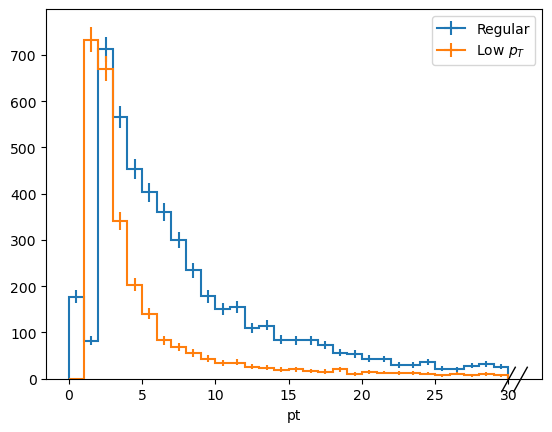

In [59]:
h_pt.plot1d(overlay='cat')
plt.legend()

## Awkward arrays

Here's a fairly detailed example of the kinds of things you can do with `awkward` arrays (the default array type with coffea/uproot) and the `numba` package. Using `numba.njit()`, you can write accelerated "event loop"-style code. This programming style is a little more intuitive than pure columnar analysis, and easier to use for quick development. I think the more technically correct way to do this would be with `vectorize`, but this seems significantly more difficult to get right

In [6]:
# load in NanoEvents
inFile = fullList[0]
events = tools.loadNano(inFile)

In this example, we'll write a for-loop algorithm that computes $\Delta R = \sqrt{\Delta \eta^2 + \Delta \phi^2}$ for every pair of electrons in each event. For technical reasons, the first argument of our jitted function needs to be an `ak.ArrayBuilder()` object to construct the output array

In [8]:
# helper function to compute deltaPhi correctly, ensuring the output is in the range [-pi,pi]
# helper functions also need to have the njit decorator to be used inside *other* jitted functions
@nb.njit()
def deltaPhiSingle(phi1,phi2):
    M_PI = 3.14159265358979323846264338328
    dPhi = np.fmod(phi1-phi2,2*M_PI)
    if dPhi < -1*M_PI:
        dPhi += 2*M_PI
    elif dPhi > M_PI:
        dPhi -= 2*M_PI
    return dPhi

# helper for compute deltaR
@nb.njit()
def deltaRSingle(eta1,phi1,eta2,phi2):
    return np.sqrt((eta1-eta2)**2 + deltaPhiSingle(phi1,phi2)**2)

# define for-loop style function for pairwise electron dR computation with nb.njit() decorator
@nb.njit()
def elePairDR(b,e1_eta,e1_phi,e2_eta,e2_phi):
    # e1_eta, e1_phi, etc. are Awkward arrays like [ [....], [....], ...., [...] ], 
    # so len(e1_eta) returns the *outer* length, i.e. the total number of events
    nEvents = len(e1_eta) 
    for n in range(nEvents):
        ne1 = len(e1_eta[n]) # number of electrons in reference collection, in this event
        ne2 = len(e2_eta[n]) # number of electrons in target colletion (to compute dR w.r.t)
        b.begin_list()
        for i in range(ne1):
            for j in range(ne2):
                dphi = deltaPhiSingle(e1_phi[n][i],e2_phi[n][j])
                dR = np.sqrt((e1_eta[n][i]-e2_eta[n][j])**2 + dphi**2)
                b.real(dR)
        b.end_list()

In [9]:
%%time
b = ak.ArrayBuilder()
reg_eles = events.Electron # normal electrons
lpt_eles = events.LptElectron # low pT electrons
elePairDR(b,reg_eles.eta,reg_eles.phi,lpt_eles.eta,lpt_eles.phi) #use jitted function to compute dR between regular and low pT electrons in each event
output = b.snapshot()

CPU times: user 1.58 s, sys: 46.8 ms, total: 1.63 s
Wall time: 2.01 s


In [10]:
output

<Array [[], [], ... 0.192, 5.52, 1.4, 4.08]] type='30486 * var * float64'>